## Imports

In [15]:
# Import packages
import pandas as pd
import numpy as np
import scipy.stats as stats
import pingouin as pg
import random
import matplotlib.pyplot as plt
import seaborn as sns

import gff2bed
import Orthoscripts

# Disable chained assignments
pd.options.mode.chained_assignment = None 

#### Import genelists

In [2]:
# Asterias rubens
Astrub = Orthoscripts.readBED("Data/Genelists/Asterias.rubens.genelist.bed")

# Holothuria leucospilota
Holleu = Orthoscripts.readBED("Data/Genelists/Holothuria.leucospilota.genelist.bed")

# Paracentrotus livides
Parliv = Orthoscripts.readBED("Data/Genelists/Paracentrotus.lividus.genelist.bed")

# Branchiostoma lanceolatum
Bralan = Orthoscripts.readBED("Data/Genelists/Branchiostoma.lanceolatum.genelist.bed")

# Branchiostoma floridae
Braflo = Orthoscripts.readBED("Data/Genelists/Branchiostoma.floridae.genelist.bed")

# Marthasterias glacialis
Margla = Orthoscripts.readBED("Data/Genelists/Marthasterias.glacialis.genelist.bed")

# Pecten maximus
Pecmax = Orthoscripts.readBED("Data/Genelists/Pecmax.genelist.bed")

# Stichopus chloronotus
Stichl = Orthoscripts.readBED("Data/Genelists/Stichopus.chloronotus.genelist.bed")

# Amphiura filiformis 
Ampfil = Orthoscripts.readBED("Data/Genelists/Amphiura.filiformis.genelist.bed")

# Ephydatia muelleri
Ephmue = Orthoscripts.readBED("Data/Genelists/Ephydatia.muelleri.genelist.bed")

# Ancestor 
Ancestor = Orthoscripts.readBED("Data/Genelists/Ancestor.genelist.bed")

#### Import ortholog files

In [3]:
# Import orthologs
Astrub_Holleu = np.loadtxt("Data/Orthologs/Asterias.rubens+Holothuria.leucospilota.txt", dtype = "str")

Astrub_Parliv = np.loadtxt("Data/Orthologs/Asterias.rubens+Paracentrotus.lividus.txt", dtype = "str")

Holleu_Parliv = np.loadtxt("Data/Orthologs/Holothuria.leucospilota+Paracentrotus.lividus.txt", dtype = "str")

Margla_Bralan = np.loadtxt("Data/Orthologs/Marthasterias.glacialis+Branchiostoma.lanceolatum.txt", dtype = "str")

Margla_Pecmax = np.loadtxt("Data/Orthologs/Marthasterias.glacialis+Pecten.maximus.txt", dtype = "str")

Margla_Stichl = np.loadtxt("Data/Orthologs/Marthasterias.glacialis+Stichopus.chloronotus.txt", dtype = "str")

Pecmax_Bralan = np.loadtxt("Data/Orthologs/Pecten.maximus+Branchiostoma.lanceolatum.txt", dtype = "str")

Stichl_Bralan = np.loadtxt("Data/Orthologs/Stichopus.chloronotus+Branchiostoma.lanceolatum.txt", dtype = "str")

Stichl_Pecmax = np.loadtxt("Data/Orthologs/Stichopus.chloronotus+Pecten.maximus.txt", dtype = "str")

Pecmax_Holleu = np.loadtxt("Orthology pipeline/orthologs/Pecmax+Holleu_sensitive.txt", dtype = "str")

Holleu_Bralan = np.loadtxt("Orthology pipeline/orthologs/Holleu+Bralan_sensitive.txt", dtype = "str")

Pecmax_Bralan = np.loadtxt("Orthology pipeline/orthologs/Pecmax+Bralan_sensitive.txt", dtype = "str")

Pecmax_Braflo = np.loadtxt("Orthology pipeline/orthologs/Pecmax+Braflo_sensitive.txt", dtype = "str")

Holleu_Braflo = np.loadtxt("Orthology pipeline/orthologs/Holleu+Braflo_sensitive.txt", dtype = "str")

Holleu_Ampfil = np.loadtxt("Data/Orthologs/Holothuria.leucospilota+Amphiura.filiformis.txt", dtype = "str")

Braflo_Ephmue = np.loadtxt("Orthology pipeline/orthologs/Braflo+Ephmue_sensitive.txt", dtype = "str")

Holleu_Ephmue = np.loadtxt("Orthology pipeline/orthologs/Holleu+Ephmue_sensitive.txt", dtype = "str")

Pecmax_Ephmue = np.loadtxt("Orthology pipeline/orthologs/Pecmax+Ephmue_sensitive.txt", dtype = "str")

#### Sorting out the data

In [4]:
Astrub = Astrub.loc[Astrub['Chromosome'].str.contains('chr')]
Bralan = Bralan.loc[Bralan['Chromosome'].str.contains('BFL_')]
Braflo = Braflo.loc[Braflo['Chromosome'].str.contains('BFL_')]
Pecmax = Pecmax.loc[Pecmax['Chromosome'].str.contains('PYE_')]

# Ephmue genelist: remove suffix
Ephmue['Name'] = Ephmue['Name'].str.rsplit('.t1').str.get(0)

# Parliv genelist: select chromosomal scaffolds
Parliv = Orthoscripts.unscaff(Parliv, 100)
Ampfil = Orthoscripts.unscaff(Ampfil, 100)
Ephmue = Orthoscripts.unscaff(Ephmue, 600)

Astrub_Parliv = Orthoscripts.orthFix(Astrub_Parliv, 'B', 'Parliv_', 1)
Margla_Bralan = Orthoscripts.orthFix(Margla_Bralan, 'A', '.1', 0)
Margla_Stichl = Orthoscripts.orthFix(Margla_Stichl, 'A', '.1', 0)
Margla_Stichl = Orthoscripts.orthFix(Margla_Stichl, 'B', '.1', 0)
Margla_Pecmax = Orthoscripts.orthFix(Margla_Pecmax, 'B', '.1', 0)
Holleu_Ampfil = Orthoscripts.orthFix(Holleu_Ampfil, 'B', '.1', 0)
Holleu_Bralan = Orthoscripts.orthFix(Holleu_Bralan, 'B', '_', 0)

##  
-----

## Plots

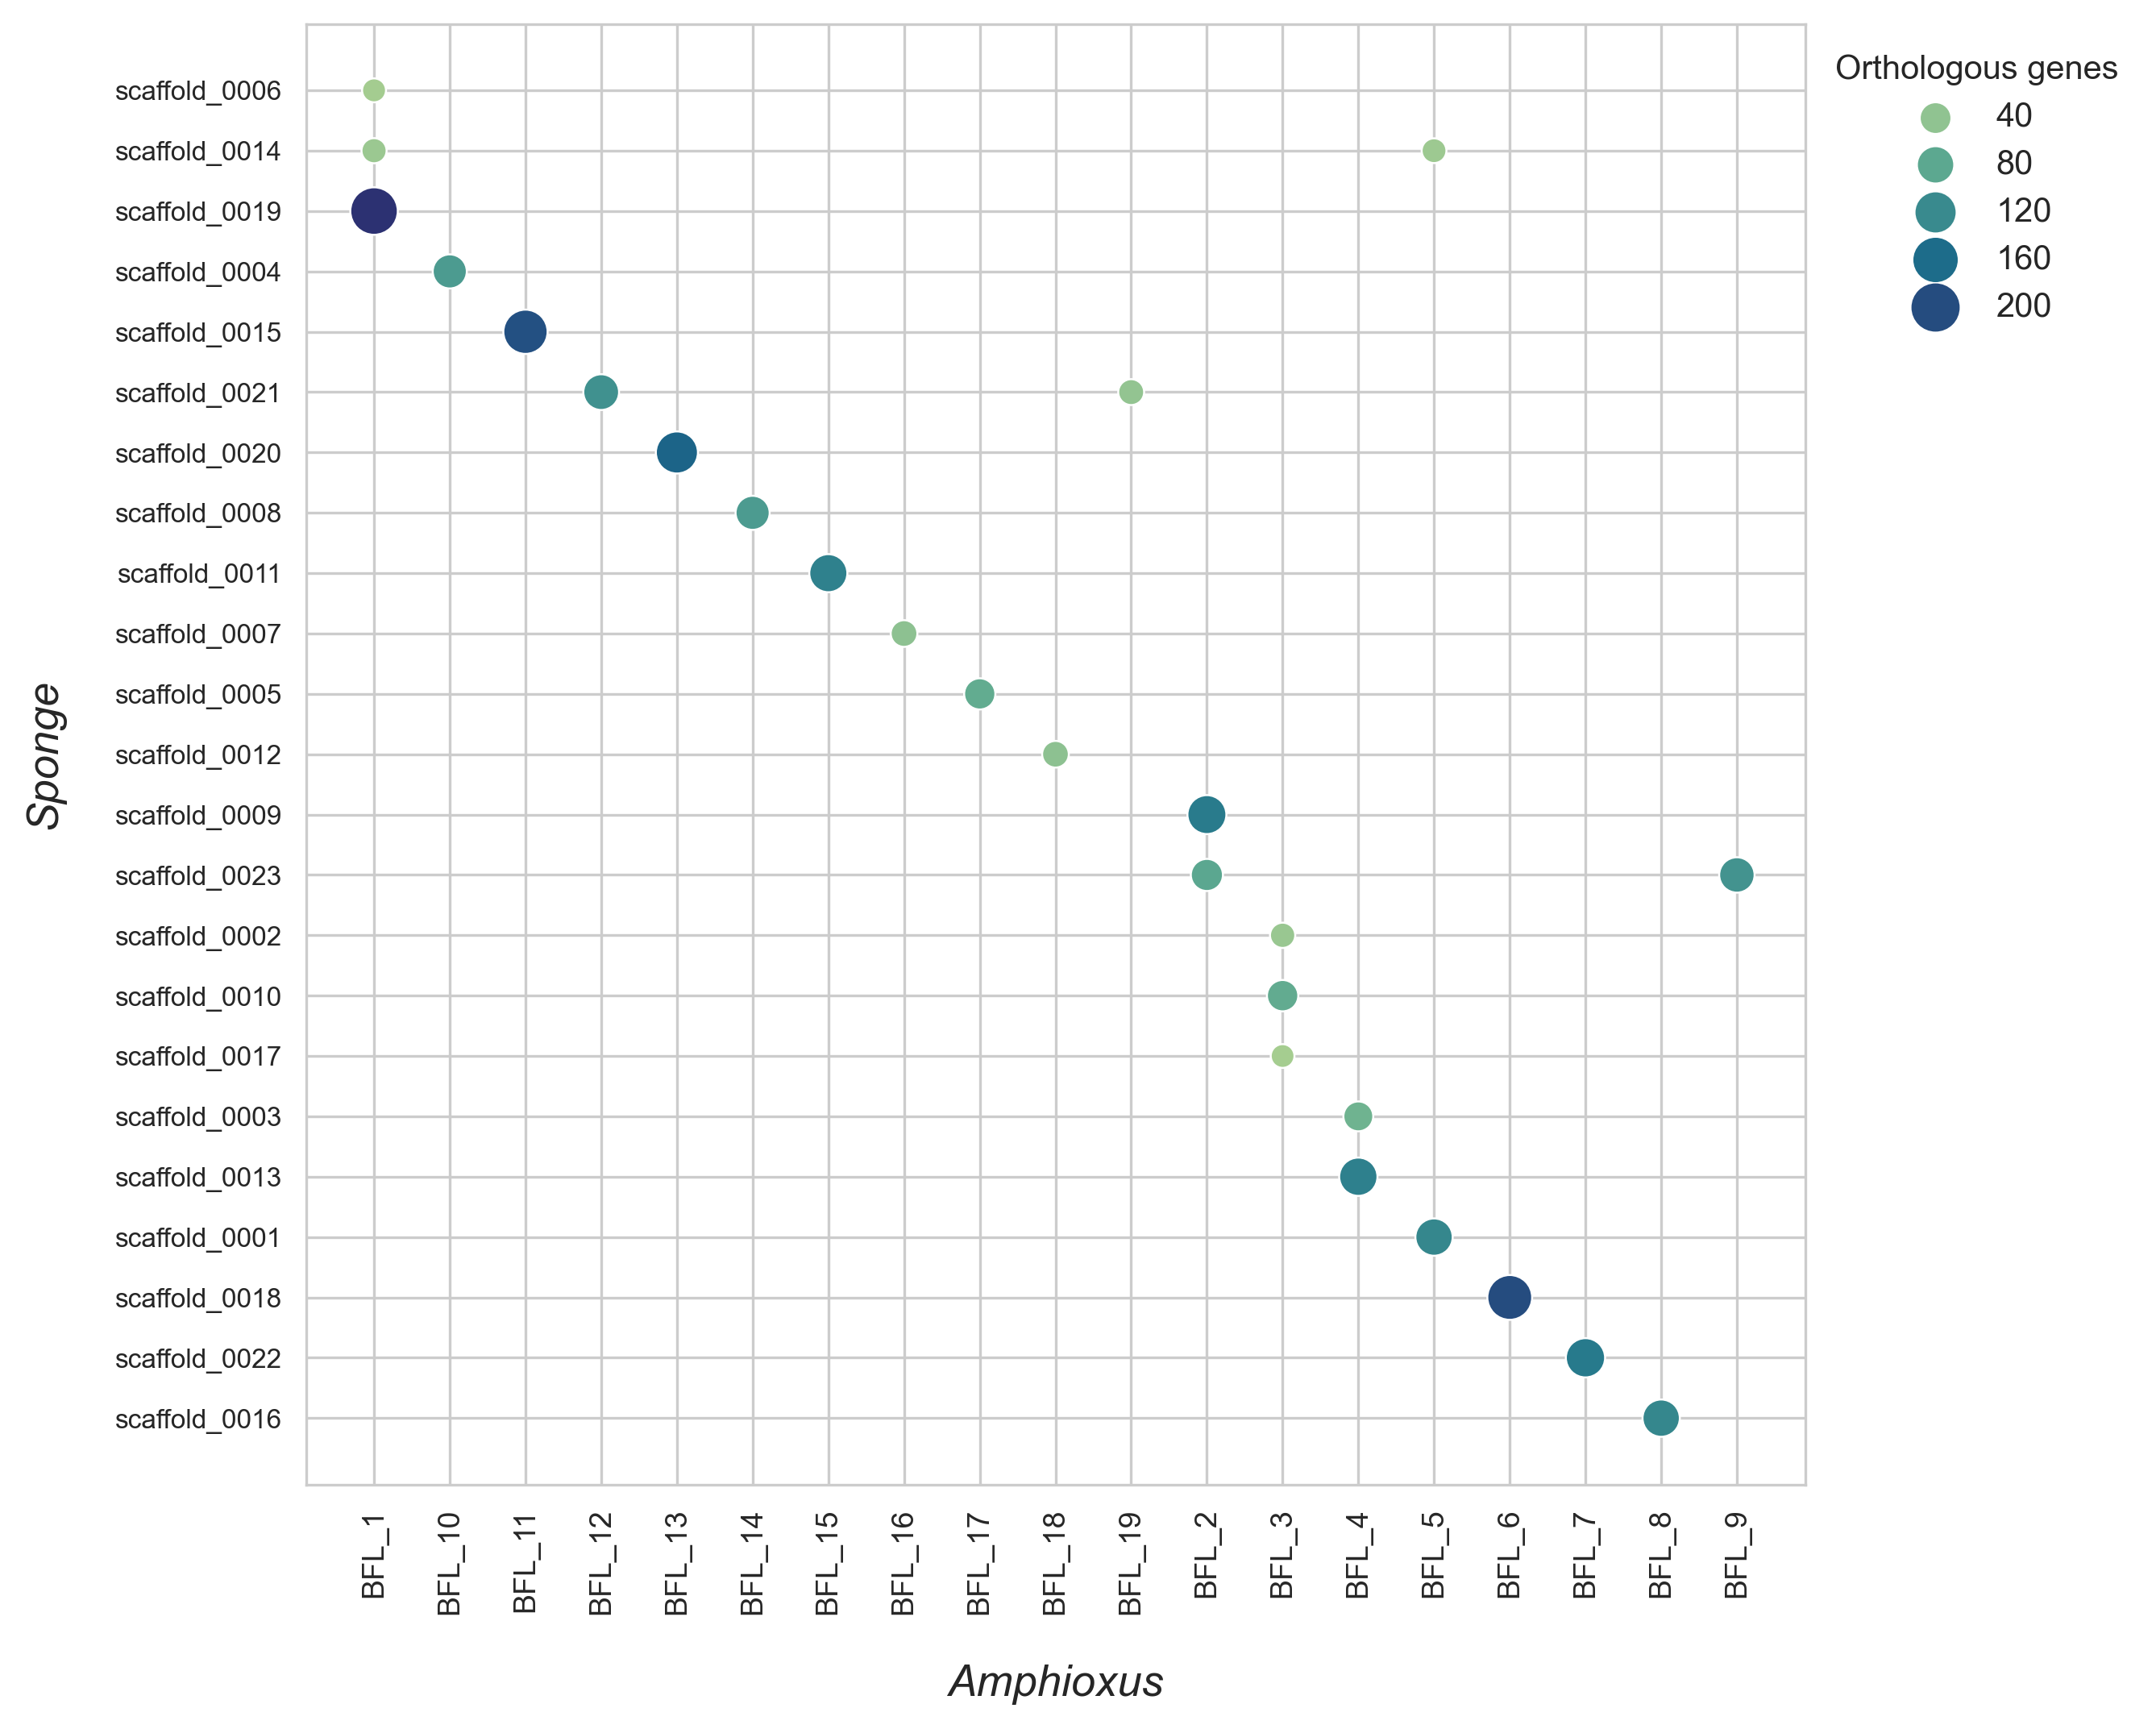

In [13]:
Orthoscripts.orthoplot(Orthoscripts.orthofind(Braflo, Ephmue, Braflo_Ephmue), 'Amphioxus', 'Sponge', 'A', 'B')

In [6]:
Orthoscripts.rearrangements(Orthoscripts.orthofind(Braflo, Ephmue, Braflo_Ephmue))

Fission of ancestral chromosome BFL_1 into ['scaffold_0006', 'scaffold_0014', 'scaffold_0019']
Fission of ancestral chromosome BFL_2 into ['scaffold_0009', 'scaffold_0023']
Fission of ancestral chromosome BFL_3 into ['scaffold_0002', 'scaffold_0010', 'scaffold_0017']
Fission of ancestral chromosome BFL_4 into ['scaffold_0003', 'scaffold_0013']
Fission of ancestral chromosome BFL_5 into ['scaffold_0001', 'scaffold_0014']
Fusion of ancestral chromosomes ['BFL_1', 'BFL_5'] into scaffold_0014
Fusion of ancestral chromosomes ['BFL_12', 'BFL_19'] into scaffold_0021
Fusion of ancestral chromosomes ['BFL_2', 'BFL_9'] into scaffold_0023


In [ ]:
def apply_fission(chrom_names, genome):
    rc = random.choice(range(len(genome)))
    chrom = genome[rc]
    name = chrom_names[rc]
    
    del genome[rc]
    del chrom_names[rc]
    
    g = random.choice(range(1, len(chrom)))
    
    chroms = [chrom[:g], chrom[g:]]
    
    genome = genome + chroms
    
    nname1 = name + '_1'
    nname2 = name + '_2'
    
    chrom_names.append(nname1)
    chrom_names.append(nname2)

-----
### Simulations

In [1]:
simAncestor = []
with open('Simulations/ancestor.geneslist.bed') as f:
    for line in f:
        simAncestor.append(line.strip().split())
simAncestor = pd.DataFrame(simAncestor, columns = ['Chromosome', 'Start', 'End', 'Name'])

simDescendant = []
with open('Simulations/speciesA.geneslist.bed') as f:
    for line in f:
        simDescendant.append(line.strip().split())
simDescendant = pd.DataFrame(simDescendant, columns = ['Chromosome', 'Start', 'End', 'Name'])

simOrthologs = np.loadtxt('Simulations/ancestor+speciesA.txt', dtype = "str")

NameError: name 'pd' is not defined

In [17]:
simAD = Orthoscripts.orthofind(simAncestor, simDescendant, simOrthologs)

simAD

,A,B,Orthologs,p-Values,Results
0,AncChr11,Chr9,100,3.543075e-74,True
1,AncChr12,Chr10,100,9.819429e-97,True
2,AncChr14,Chr4,100,1.704118e-155,True
3,AncChr15,Chr5,100,1.704118e-155,True
4,AncChr16,Chr6,100,1.704118e-155,True
5,AncChr17,Chr7,100,1.704118e-155,True
6,AncChr18,Chr8,100,9.819429e-97,True
7,AncChr2,Chr8,100,9.819429e-97,True
8,AncChr3,Chr1,100,1.704118e-155,True
9,AncChr4,Chr2,100,1.704118e-155,True


In [18]:
Orthoscripts.rearrangements(simAD)

Fusion of ancestral chromosomes ['AncChr12', 'AncChr8'] into Chr10
Fusion of ancestral chromosomes ['AncChr18', 'AncChr2'] into Chr8
Fusion of ancestral chromosomes ['AncChr11', 'AncChr5', 'AncChr7'] into Chr9
